# Idealized Profiles Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import gsw
from cmocean import cm
from importlib import reload
import scipy.ndimage as filter

In this notebook, I'm using functions I've already written for tasks such as filtering, calculating the mixed layer depth, and accessing variance metrics. For increased "readability" I've copied and pasted them directly into this noteobok so it's easy to check the code itself if there are any questions or uncertainties.

Broadly speaking, there are two sections. The first heading starts here, performing a Steinberg-style analysis on one profile. The next section is **Ensemble Averaging** and deals with how to create a new filtering method that is not impacted by the large-scale gradient.

# Steinberg Analysis

### Creating Profiles

In [2]:
depth_grid = np.linspace(0,2000,1000)
temp_exp = np.exp(-depth_grid/150)*10
psal_exp = (-np.exp(-depth_grid/550)*2)+35

In [3]:
temp_noise = (1/5)*np.sin((1/25)*(depth_grid))
psal_noise = (1/25)*np.sin((1/40)*(depth_grid))

In [4]:
temp_prof = temp_exp + temp_noise[::-1]
psal_prof = psal_exp + psal_noise[::-1]

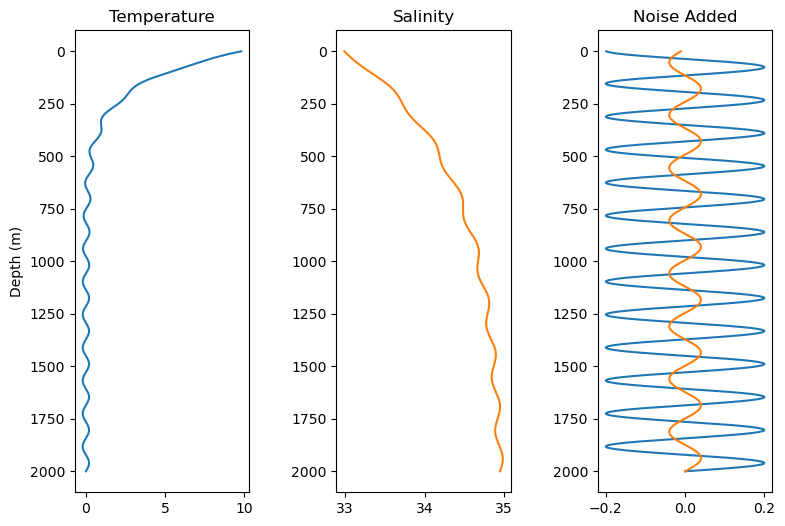

In [5]:
plt.figure(figsize=(9,6))
plt.subplot(131)
plt.plot(temp_prof,  depth_grid,color='tab:blue')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.title('Temperature')

plt.subplot(132)
plt.plot(psal_prof  ,depth_grid,color='tab:orange')
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(133)
plt.plot(temp_noise[::-1],depth_grid)
plt.plot(psal_noise[::-1],depth_grid)
plt.gca().invert_yaxis()
plt.title('Noise Added')

plt.subplots_adjust(wspace=0.5)

The above plot shows idealized profiles of temperature and salinity, where the overall signal is the sum of a large-scale exponential gradient and small-scale variation from a sine wave. I tried to keep the values somewhat realistic because I will next calculate density and spice for the profile using the gsw package.

In [6]:
dens_prof = gsw.density.rho(psal_prof,temp_prof,depth_grid)
spic_prof = gsw.spiciness0(psal_prof,temp_prof)

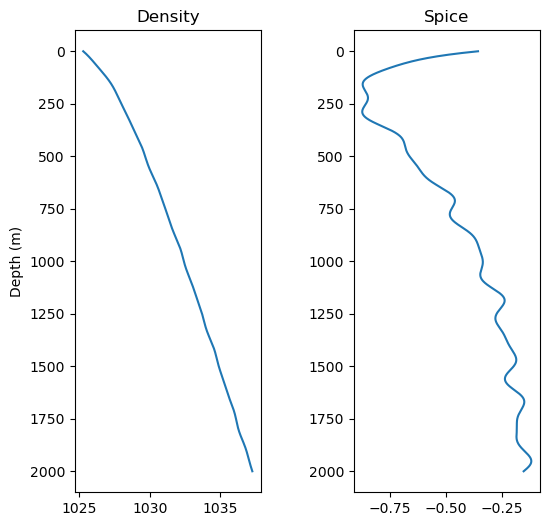

In [7]:
plt.figure(figsize=(6,6))

plt.subplot(121)
plt.plot(dens_prof,depth_grid)
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.title('Density')

plt.subplot(122)
plt.plot(spic_prof,depth_grid)
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplots_adjust(wspace=0.5)

In [8]:
temp_stack = np.vstack((temp_prof,temp_prof))
psal_stack = np.vstack((psal_prof,psal_prof))
dens_stack = np.vstack((dens_prof,dens_prof))
spic_stack = np.vstack((spic_prof,spic_prof))

In [9]:
#create a float-style dataset with coordinates temperature, salinity, and spice and dimensions profile and depth
#there are two profiles, but they are identical

ds = xr.Dataset(coords=dict(profile=(['profile'],np.array([0,1])),
                           depth=(['depth'],depth_grid)),
           data_vars=dict(temperature=(['profile','depth'],temp_stack),
                          salinity=(['profile','depth'],psal_stack),
                          density=(['profile','depth'],dens_stack),
                          spice=(['profile','depth'],spic_stack)))

In [10]:
# add mixed layer depth as a coordinate in ds
#this function is from MLD_funcs.py
def get_MLD(ds,threshold=0.03,variable='SIG0',dim1='N_PROF',dim2='PRES_INTERPOLATED'):
    '''Takes an xarray and returns a new coordinate "MLD" or mixed layer depth for each profile, defined using the density threshold from the surface.
    ds: xarray with profile and pressure dimensions
    threshold: density value that defines the boundary of the mixed layer, default=0.03
    variable: density coordinate, default='SIG0'
    dim1: profile dimension, default='N_PROF'
    dim2: pressure dimension, default='PRES_INTERPOLATED'
    '''
    
    MLD_li = []
    
    for n in range(0, len(ds[dim1])):
        SIG0_surface = ds.isel({dim1:n})[variable].isel({dim2:0})
        SIG0_diff    = SIG0_surface + threshold
        MLD_ds       = SIG0_surface.where(ds.isel({dim1:n})[variable] < SIG0_diff)
        MLD          = MLD_ds.dropna(dim2).isel({dim2:-1})[dim2].values
        MLD_li.append(MLD)
        
    return ds.assign_coords(MLD=(dim1,MLD_li))

ds = get_MLD(ds,dim1='profile',dim2='depth',variable='density')
ds

<xarray.Dataset>
Dimensions:      (profile: 2, depth: 1000)
Coordinates:
  * profile      (profile) int64 0 1
  * depth        (depth) float64 0.0 2.002 4.004 ... 1.996e+03 1.998e+03 2e+03
    MLD          (profile) float64 0.0 0.0
Data variables:
    temperature  (profile, depth) float64 9.801 9.671 9.544 ... 0.01602 1.62e-05
    salinity     (profile, depth) float64 32.99 32.99 33.0 ... 34.95 34.95 34.95
    density      (profile, depth) float64 1.025e+03 1.025e+03 ... 1.037e+03
    spice        (profile, depth) float64 -0.3556 -0.3743 ... -0.1491 -0.1514

I included this MLD function here because the filtering function used later on requires a MLD input in order to start the mask in the correct position, situated one filter scale below the mixed layer.

In [11]:
temp_grad = np.gradient(ds.temperature.isel(profile=0))
psal_grad = np.gradient(ds.salinity.isel(profile=0))
spic_grad = np.gradient(ds.spice.isel(profile=0))

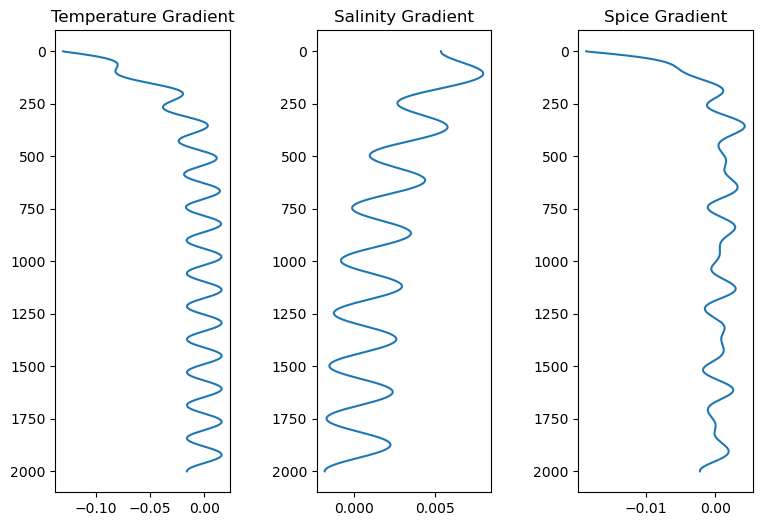

In [12]:
plt.figure(figsize=(9,6))

plt.subplot(131)
plt.plot(temp_grad,depth_grid)
plt.gca().invert_yaxis()
plt.title('Temperature Gradient')

plt.subplot(132)
plt.plot(psal_grad,depth_grid)
plt.gca().invert_yaxis()
plt.title('Salinity Gradient')

plt.subplot(133)
plt.plot(spic_grad,depth_grid)
plt.gca().invert_yaxis()
plt.title('Spice Gradient')

plt.subplots_adjust(wspace=0.5)

This doesn't feel very relevant right now. Maybe remove the gradient piece, or at least move it to somewhere else in the notebook.

### Filtering Methods

In [20]:
#assign filter scale
lfilter = 150
variable='temperature'

In [21]:
#convert scale from meters to gridpoints
#this function is from filt_funcs.py
def get_nfilter(ds, lfilter, dim2='PRES_INTERPOLATED'):
    
    '''Takes an xarray (to determine dx) and a filter scale in meters. Returns the corresponding filter scale in gridpoints.
    
    ds: xarray dataset with pressure dimension
    lfilter: filter scale in meters
    dim2: pressure dimension, filtering occurs along this dimension, default=PRES_INTERPOLATED'''
    
    dx = (ds[dim2].isel({dim2:1})-ds[dim2].isel({dim2:0})).values
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx
    
    return nfilter

I know we already went through this, but I don't exactly remember where this factor of $\sqrt{12}$ comes from. Worth putting notes here describing each step of this correction from meters to gridpoints

In [22]:
#create a mask with zeros on the upper bound of MLD+lfilter, and a lower bound of lfilter (and ones between)
#this function is from filt_funcs.py
def get_mask(ds, scale, variable_MLD='MLD', dim1='profile', dim2='depth', bound=True):
    
    '''Takes an xarray and returns a dim1 length list of 1d np arrays with length of dim2 that contains:
    1) bound=False: ones
    2) bound=True: zeroes one filter scale away from the top (ML base) and bottom (profile bottom) boundaries, and ones between.
    
    ds: xarray dataset with pressure dimension
    scale: int/float, used to determine the amount of pressures that will go to zero
    variable: coordinate of mixed layer depth, default=MLD
    dim1: profile dimension, default=N_PROF
    dim2: pressure dimension, filtering occurs along this dimension, defualt=PRES_INTERPOLATED
    bound: will boundary regions become zeros?, default=False'''

    mask_li = []
    
    if bound==False:
        for n in range(0,len(ds[dim1])):
            mask = np.ones((len(ds[dim2])))
            mask_li.append(mask)
        
    if bound==True:
        for n in range(0,len(ds[dim1])):
            start = ds[variable_MLD][n].values + scale
            end = ds[dim2].isel({dim2:-1}).values - scale
            mask = ds[dim2].where(ds[dim2]>start).where(ds[dim2]<end).values
            
            mask[np.greater(mask,0)] = 1
            mask[np.isnan(mask)] = 0
            mask_li.append(mask)
    
    return mask_li

In [23]:
#filter profiles
#this function is from filt_funcs.py
def get_filt_single(ds, lfilter, variable, dim1='profile', dim2='depth', bound=True):
    
    '''Takes an xarray and a filter scale in meters and returns an xarray with additional coordinates N_PRPF_NEW for a sequence that can be plotted and MASK for the boundary correction.
    
    ds: xarray dataset with pressure dimension
    lfilter: filter scale in meters
    variable: coordinate to filter, default=CT
    dim1: profile dimension, default=N_PROF
    dim2: pressure dimension, filtering occurs along this dimension, default=PRES_INTERPOLATED
    bound: will boundary regions become zeros?, default=True'''
    
    mask_li = get_mask(ds, lfilter, variable_MLD='MLD', dim1=dim1, dim2=dim2, bound=bound)
    
    nfilter = get_nfilter(ds, lfilter, dim2=dim2)
    
    temp = np.zeros((ds[dim1].shape[0], ds[dim2].shape[0]))
    temp[:,:] = filter.gaussian_filter1d(ds[variable], sigma=nfilter, mode='nearest')
    
    ds_filt = xr.DataArray(temp, dims=[dim1, dim2], coords={dim1:ds[dim1], dim2:ds[dim2]})
    #ds_filt = ds_filt.assign_coords(LATITUDE=(dim1,ds.LATITUDE.data))
    #ds_filt = ds_filt.assign_coords(LONGITUDE=(dim1,ds.LONGITUDE.data))
    
    ds_filt=ds_filt.assign_coords(mask=((dim1,dim2),mask_li))
    
    return ds_filt

In [24]:
ds_filt_temp = get_filt_single(ds, lfilter, variable='temperature', dim1='profile', dim2='depth')
ds_filt_psal = get_filt_single(ds, lfilter, variable='salinity', dim1='profile', dim2='depth')
ds_filt_spic = get_filt_single(ds, lfilter, variable='spice', dim1='profile', dim2='depth')

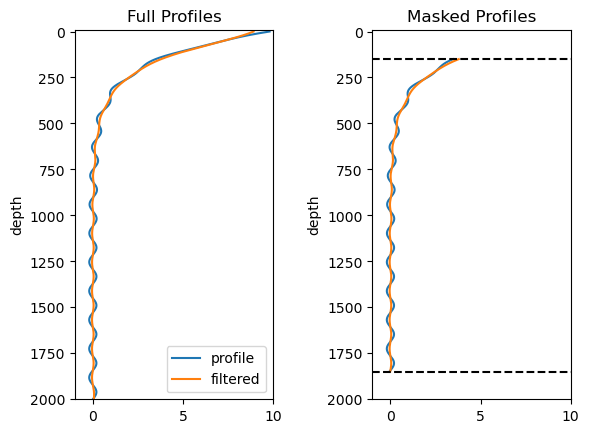

In [25]:
plt.subplot(121)
ds.temperature.isel(profile=0).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).plot(y='depth',label='filtered')
plt.ylim(-10,2000)
plt.xlim(-1,10)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Full Profiles')

plt.subplot(122)
ds.temperature.isel(profile=0).where(ds_filt_temp.isel(profile=0).mask==1).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).where(ds_filt_temp.isel(profile=0).mask==1).plot(y='depth',label='filtered')
plt.hlines(y=[ds.MLD.isel(profile=0)+lfilter,ds.depth.max()-lfilter],xmin=-1,xmax=10,color='k',linestyle='--')
plt.ylim(-10,2000)
plt.xlim(-1,10)
plt.gca().invert_yaxis()
plt.title('Masked Profiles')

plt.subplots_adjust(wspace=0.5)

This is a check to make sure the filtering function does what we expect (ie remove the noise from the profile, leaving only the large-scale signal).

### Variance Framework

In [26]:
#square a filtered profile
#this function is from EKE_funcs.py
def get_filt_squared(ds, lfilter, variable,dim1='profile',dim2='depth',bound=True):
    
    ds_filt = get_filt_single(ds, lfilter, variable=variable, dim1=dim1, dim2=dim2, bound=bound)
    ds_filt_squared = ds_filt**2
    
    return ds_filt_squared

In [27]:
#filter a squared profile
#this function is from EKE_funcs.py
def get_squared_filt(ds, lfilter, variable,dim1='profile',dim2='depth',bound=True):
    
    ds_squared = ds[[variable]]**2
    ds_squared_filt = get_filt_single(ds_squared, lfilter, variable=variable, dim1=dim1, dim2=dim2,bound=bound)
    
    return ds_squared_filt

In [28]:
#calculate EKE
#this function is from EKE_funcs.py
def get_EKE(ds, lfilter, variable,dim1='profile',dim2='depth',bound=True):
    
    ds_filt_squared = get_filt_squared(ds, lfilter, dim1=dim1, dim2=dim2, variable=variable,bound=bound)
    ds_squared_filt = get_squared_filt(ds, lfilter, dim1=dim1, dim2=dim2, variable=variable,bound=bound)
    ds_EKE = ds_squared_filt - ds_filt_squared
    
    return ds_EKE

In [29]:
ds_EKE_temp = get_EKE(ds,lfilter,variable='temperature')
ds_EKE_psal = get_EKE(ds,lfilter,variable='salinity')
ds_EKE_spic = get_EKE(ds,lfilter,variable='spice')

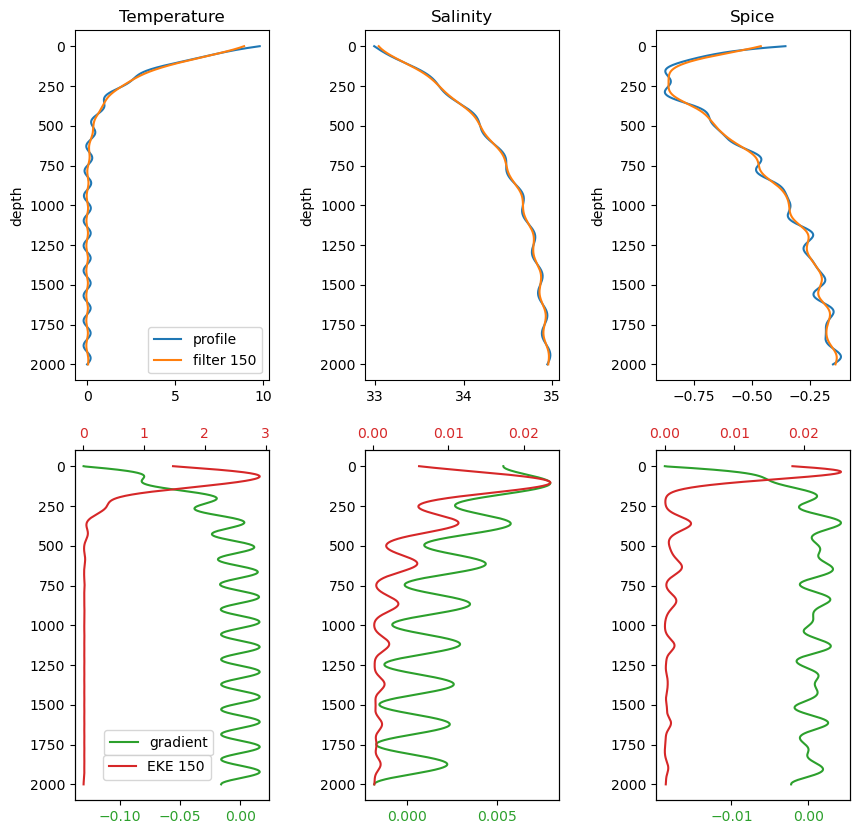

In [33]:
plt.figure(figsize=(10,10))

plt.subplot(231)
ds.temperature.isel(profile=0).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).plot(y='depth',label='filter {}'.format(lfilter))
plt.gca().invert_yaxis()
plt.legend()
plt.title('Temperature')

plt.subplot(232)
ds.salinity.isel(profile=0).plot(y='depth')
ds_filt_psal.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(233)
ds.spice.isel(profile=0).plot(y='depth')
ds_filt_spic.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplot(234)
plt.plot(temp_grad,depth_grid,color='tab:green',label='gradient')
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(0.75,0.22))
plt.xticks(color='tab:green')
plt.twiny()
ds_EKE_temp.isel(profile=0).plot(y='depth',color='tab:red',label='EKE {}'.format(lfilter))
plt.xticks(color='tab:red')
plt.legend(bbox_to_anchor=(0.11,0.15))
plt.title('')

plt.subplot(235)
plt.plot(psal_grad,depth_grid,color='tab:green')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_EKE_psal.isel(profile=0).plot(y='depth',color='tab:red')
plt.xticks(color='tab:red')
plt.title('')

plt.subplot(236)
plt.plot(spic_grad,depth_grid,color='tab:green')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_EKE_spic.isel(profile=0).plot(y='depth',color='tab:red')
plt.xticks(color='tab:red')
plt.title('')

plt.subplots_adjust(wspace=0.5)

This plot is meant to compare the profile's EKE and gradient, for each of temperature, salinity, and spice. The top panels show the original profile and the filtered profile. The bottom pannels show the EKE for that tracer (in red) and the gradient (in green). For each, the EKE is greatest where the gradient is minimzed. 

In [25]:
ds_fs_temp = get_filt_squared(ds,lfilter,variable='temperature')
ds_fs_psal = get_filt_squared(ds,lfilter,variable='salinity')
ds_fs_spic = get_filt_squared(ds,lfilter,variable='spice')

ds_sf_temp = get_squared_filt(ds,lfilter,variable='temperature')
ds_sf_psal = get_squared_filt(ds,lfilter,variable='salinity')
ds_sf_spic = get_squared_filt(ds,lfilter,variable='spice')

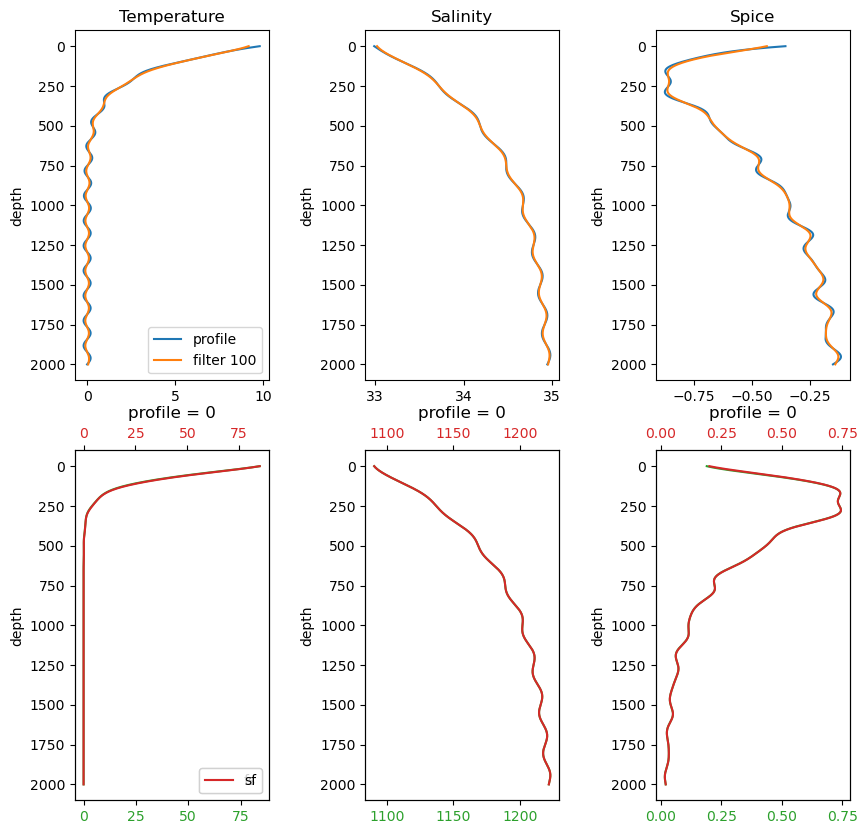

In [26]:
plt.figure(figsize=(10,10))

plt.subplot(231)
ds.temperature.isel(profile=0).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).plot(y='depth',label='filter 100')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Temperature')

plt.subplot(232)
ds.salinity.isel(profile=0).plot(y='depth')
ds_filt_psal.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(233)
ds.spice.isel(profile=0).plot(y='depth')
ds_filt_spic.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplot(234)
ds_fs_temp.isel(profile=0).plot(y='depth',color='tab:green',label='fs')
plt.gca().invert_yaxis()
plt.legend()
plt.xticks(color='tab:green')
plt.twiny()
ds_sf_temp.isel(profile=0).plot(y='depth',color='tab:red',label='sf')
plt.xticks(color='tab:red')
plt.legend()
plt.title('')

plt.subplot(235)
ds_fs_psal.isel(profile=0).plot(y='depth',color='tab:green',label='fs')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_sf_psal.isel(profile=0).plot(y='depth',color='tab:red',label='sf')
plt.xticks(color='tab:red')
plt.title('')

plt.subplot(236)
ds_fs_spic.isel(profile=0).plot(y='depth',color='tab:green',label='fs')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_sf_spic.isel(profile=0).plot(y='depth',color='tab:red',label='sf')
plt.xticks(color='tab:red')
plt.title('')

plt.subplots_adjust(wspace=0.5)

# Ensemble Approach

This is the next section of the notebook. If calculating a filtered variance term for each profile seems to produce errors, what if we introduce ensemble averaging? First I construct a ds of profiles with varying phases, then I apply ensemble averaging to Steinberg's method. Finally, I start from combining the concept of T'(z) with the definition of variance, and try to reconcile this with Steinberg's spatial filtering.

Above, the noise added to each profile is described as below:
 
    temp_noise = (1/5)*np.sin((1/25)*(depth_grid))
    psal_noise = (1/25)*np.sin((1/40)*(depth_grid-50))

Here, I think we can keep the same form, just add in a random value of $\phi$ to each profile. Then, density and salinity should be calculated for each profile

In [34]:
low  = -5
high =  5

temps = np.ones([100,1000])
psals = np.ones([100,1000])
denss = np.ones([100,1000])
spics = np.ones([100,1000])

temp_noises = np.ones([100,1000])
psal_noises = np.ones([100,1000])

for n in range(0,100):
    
    temp_random = np.random.uniform(low,high)
    psal_random = np.random.uniform(low,high)

    #temperature and salinity have separate waves
    temp_noise = (1/5) *np.sin((1/25)*(depth_grid)+temp_random)
    psal_noise = (1/25)*np.sin((1/40)*(depth_grid)+psal_random)
    
    temp_prof = temp_exp + temp_noise
    psal_prof = psal_exp + psal_noise
    
    dens_prof = gsw.density.rho(psal_prof,temp_prof,depth_grid)
    spic_prof = gsw.spiciness0(psal_prof,temp_prof)
    
    temps[n] = temp_prof
    psals[n] = psal_prof
    denss[n] = dens_prof
    spics[n] = spic_prof

    #noise is also stored so it can be accessed for checking later
    temp_noises[n] = temp_noise
    psal_noises[n] = psal_noise

In [35]:
ds_ensemble = xr.Dataset(coords=dict(profile=(['profile'],range(0,100)),
                           depth=(['depth'],depth_grid)),
           data_vars=dict(temperature=(['profile','depth'],temps),
                          salinity=(['profile','depth'],psals),
                          density=(['profile','depth'],denss),
                          spice=(['profile','depth'],spics),
                          temp_noise=(['profile','depth'],temp_noises),
                          psal_noise=(['profile','depth'],temp_noises)))

In [36]:
ds_ensemble = get_MLD(ds_ensemble,dim1='profile',dim2='depth',variable='density')
ds_ensemble

<xarray.Dataset>
Dimensions:      (profile: 100, depth: 1000)
Coordinates:
  * profile      (profile) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * depth        (depth) float64 0.0 2.002 4.004 ... 1.996e+03 1.998e+03 2e+03
    MLD          (profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    temperature  (profile, depth) float64 10.19 10.06 9.933 ... 0.1907 0.1949
    salinity     (profile, depth) float64 33.04 33.04 33.05 ... 34.93 34.93
    density      (profile, depth) float64 1.025e+03 1.025e+03 ... 1.037e+03
    spice        (profile, depth) float64 -0.2547 -0.2728 ... -0.1486 -0.1495
    temp_noise   (profile, depth) float64 0.1877 0.1926 0.1963 ... 0.1907 0.1949
    psal_noise   (profile, depth) float64 0.1877 0.1926 0.1963 ... 0.1907 0.1949

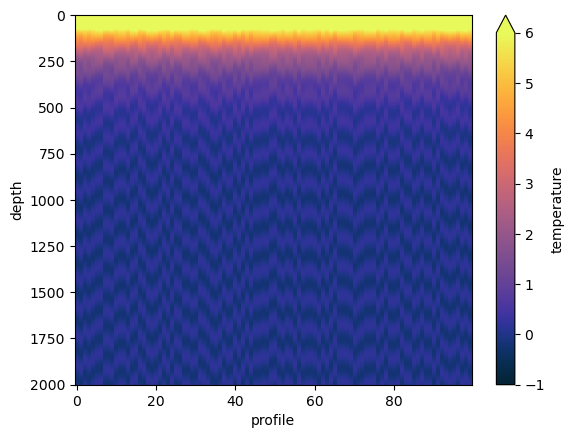

In [37]:
ds_ensemble.temperature.plot(y='depth',cmap=cm.thermal,vmin=-1,vmax=6)
plt.gca().invert_yaxis()

This is the temperature field generated by changing phase values

In [39]:
#calculate Steinberg EKE values for plotting below

temp_filt         = get_filt_single(ds_ensemble,lfilter,variable='temperature')
temp_filt_squared = temp_filt**2

temp_squared      = ds_ensemble[[variable]]**2
temp_squared_filt = get_filt_single(temp_squared,lfilter,variable='temperature')

temp_EKE          = get_EKE(ds_ensemble,lfilter,variable='temperature')

In [61]:
#calculate expected values of Steinberg EKE values using sin functions
#in other words, can I replicate the results from the box above by reconstructing the sin functions?

prof=0

test_filt         = (10)*(np.exp(-depth_grid/150))
test_filt_squared = (10**2)*(np.exp(-depth_grid/150)**2)

test_squared      = (10**2)*(np.exp(-depth_grid/150)**2) + ds_ensemble.temp_noise.isel(profile=prof)**2 + 2*(10)*(1/5)*(np.exp(-depth_grid/150))*(ds_ensemble.temp_noise.isel(profile=0))
test_squared_filt = (10**2)*(np.exp(-depth_grid/150)**2) + ((1/5)**2)*(ds_ensemble.temp_noise.isel(profile=prof)**2)

test_EKE          = test_squared_filt - test_filt_squared

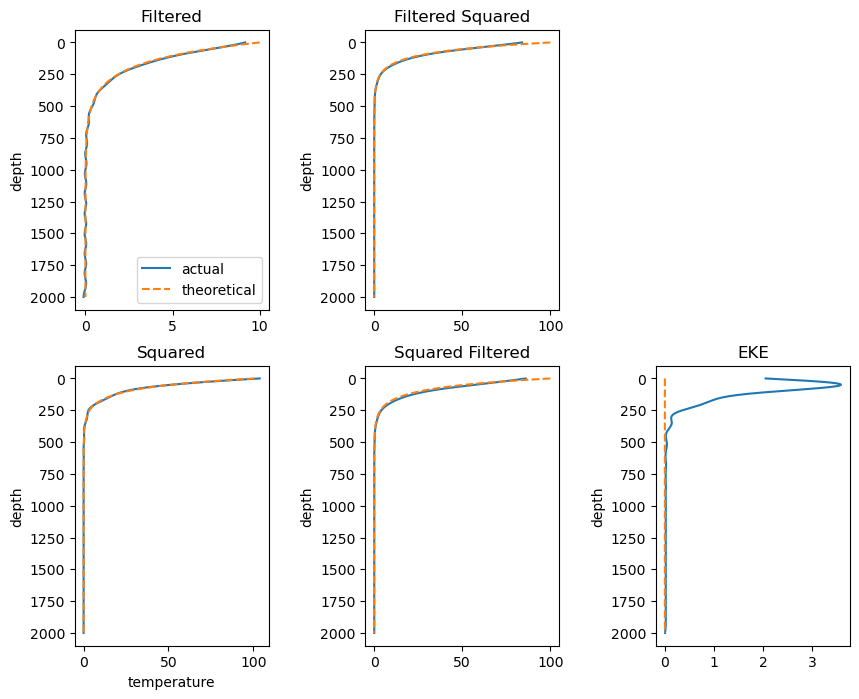

In [62]:
plt.figure(figsize=(10,8))

plt.subplot(231)
temp_filt.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_filt,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Filtered')

plt.subplot(232)
temp_filt_squared.isel(profile=0).plot(y='depth',label='actual')
plt.plot(test_filt_squared,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('Filtered Squared')

plt.subplot(234)
temp_squared.temperature.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_squared,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('Squared')

plt.subplot(235)
temp_squared_filt.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_squared_filt,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('Squared Filtered')

plt.subplot(236)
temp_EKE.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_EKE,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('EKE')

plt.subplots_adjust(wspace=0.5)

This plot is meant to show the contribution of each term to the overall EKE value. In blue is the "actual" value as calculated by my EKE functions. In orange is the "theoretical" value calculated based on our assumptions noted on the white board. I think the point here is that the cross term between the large-scale gradient and the noise does not go away in the "actual" profile as predicted. I'm not entirely sure why the theoretical value looks like a straight line, this is something to look into later.

Note that no ensemble averaging has been done yet, this is just selecting a profile from the dataset and checking.

Text(0.5, 1.0, 'EKE')

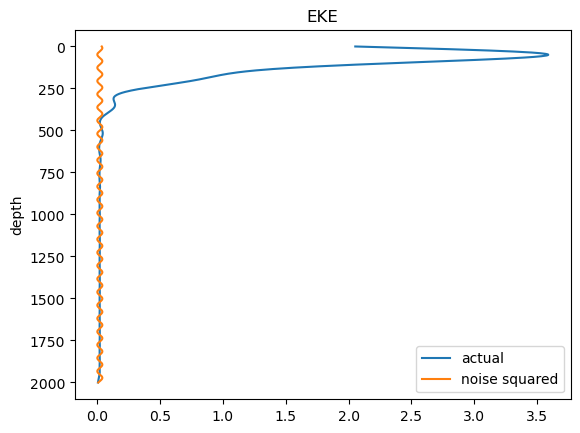

In [68]:
temp_EKE.isel(profile=prof).plot(y='depth',label='actual')
#plt.plot(test_EKE,depth_grid,label='theoretical')
#plt.plot(ds_ensemble.temp_noise.isel(profile=prof),depth_grid,label='noise added')
plt.plot(ds_ensemble.temp_noise.isel(profile=prof)**2,depth_grid,label='noise squared')
plt.gca().invert_yaxis()
plt.legend()
plt.title('EKE')

The point I'm trying to make in this plot is that the noise added (orange) is only a sin function, however the EKE calculation produces a result that's a function of both the large-scale gradient and also the small-scale noise. Also note that no ensemble averaging has occured yet! This is just selecting a profile from the opti

In [44]:
temp_squared_bar      = temp_squared.mean('profile')
temp_squared_bar      = temp_squared_bar.assign_coords(profile=(('profile'),np.array([0])))
temp_squared_bar      = temp_squared_bar.assign_coords(MLD=(('profile'),np.array([0])))
temp_squared_bar_filt = get_filt_single(temp_squared_bar,lfilter,variable='temperature')

**NOTE:**
There was a problem with the above cell, where the function get_filt_single would return an error because if you feed it temp_squared_bar directly (with no processing), it no longer has a profile dimension. The function requires this, so I added a profile dimension and picked the value of 0. It also requires a MLD coordinate (to determine where to set the mask) so I also set this to zero. This will require more careful attention in the future, but this hacky solution works for now.

In [45]:
temp_bar = ds_ensemble.temperature.mean('profile')
temp_bar = xr.Dataset(coords=dict(depth=(['depth'],depth_grid)),
                      data_vars=dict(temperature=(['depth'],temp_bar.data)))
temp_bar = temp_bar.assign_coords(profile=(('profile'),np.array([0])))
temp_bar = temp_bar.assign_coords(MLD=(('profile'),np.array([0])))
temp_bar_filt = get_filt_single(temp_bar,lfilter,variable='temperature')
temp_bar_filt_squared = temp_bar_filt**2

**NOTE:** 
There were similar problems as with the cell above, so I implemented a similar solution. There was an additional error because the initial line for `temp_bar` returns a DataArray instead of a Dataset, so I first created a new Dataset, then added an additional dimension of profile and an additional coordinate of MLD.

In [46]:
temp_variance = (ds_ensemble.temperature**2).mean('profile') - ds_ensemble.temperature.mean('profile')**2

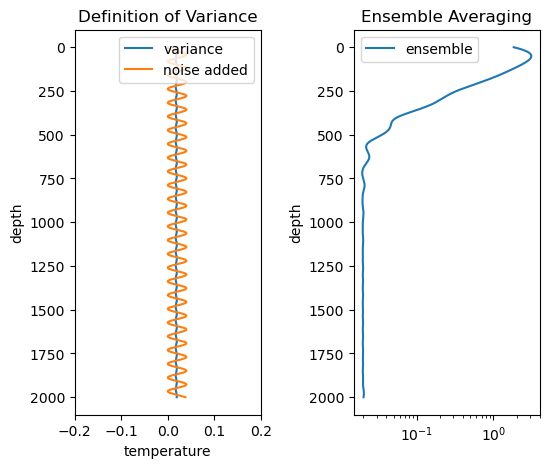

In [47]:
plt.figure(figsize=(6,5))

plt.subplot(121)
temp_variance.plot(y='depth',label='variance')
plt.plot(temp_noise**2,depth_grid,label='noise added')
plt.xlim(-0.2,0.2)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Definition of Variance')

plt.subplot(122)
(temp_squared_bar_filt-temp_bar_filt_squared).plot(y='depth',label='ensemble')
#plt.plot(temp_noise**2,depth_grid,label='noise added')
plt.gca().invert_yaxis()
plt.legend()
plt.xscale('log')
plt.title('Ensemble Averaging')

plt.subplots_adjust(wspace=0.5)

The goal of this plot is to compare a pure variance method without filtering (left) to adding ensemble averaging to the Steinberg analysis. I probably wasn't very careful with the placement of the "bar" operator though. See the coming sections for a more careful look at how to combine ensemble averaging with the Steinberg-style EKE method. The important takeaway here is that ensemble averaging didn't seem to remove the large-scale gradient.

### Variance without any filtering

In [49]:
ds_anom = ds_ensemble.temperature - ds_ensemble.temperature.mean('profile')
ds_var = (ds_anom**2).mean('profile')

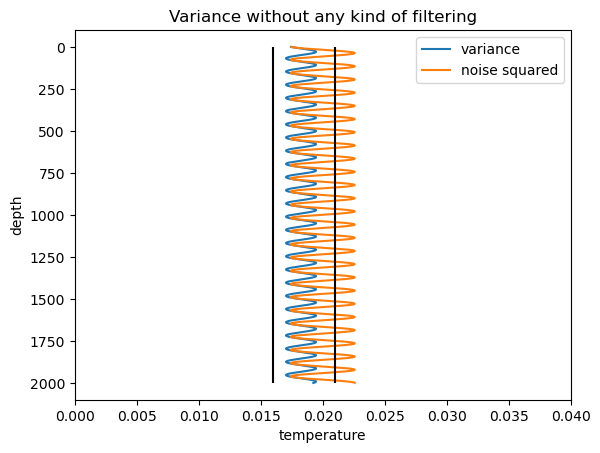

In [50]:
ds_var.plot(y='depth',label='variance')
plt.plot((ds_ensemble.temp_noise**2).mean('profile'),depth_grid, label='noise squared')
plt.gca().invert_yaxis()
plt.xlim(0,0.04)
plt.vlines([0.016,0.021],2000,0,color='k')
plt.title('Variance without any kind of filtering')
plt.legend()

Two important takeaways here:
- For the first time, the result of a metric is only recovering a sin function! This is good progress
- However, it's not exactly what would be expected, meaning it's not exactly recovering the noise added to the profile. Additionaly, since no filtering was involved in making this plot, it's difficult to say what scales are contributing to this signal.

Text(0.5, 1.0, 'What I thought the above metric is doing')

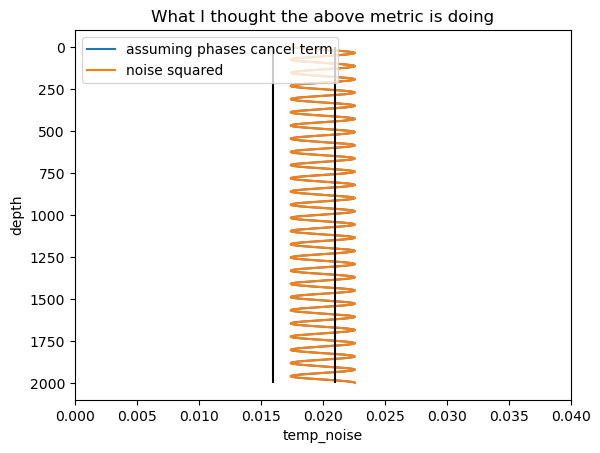

In [55]:
(ds_ensemble.temp_noise**2).mean('profile').plot(y='depth',label='assuming phases cancel term')
plt.plot((ds_ensemble.temp_noise**2).mean('profile'),depth_grid, label='noise squared')
plt.gca().invert_yaxis()
plt.xlim(0,0.04)
plt.legend()
plt.vlines([0.016,0.021],2000,0,color='k')
plt.title('What I thought the above metric is doing')

This confirms that if a variety of phases were correctly defined over many profiles, and the ensemble average of sin(kx+phi) goes to zero, the output of the variance equation would equal the noise added. In other words, a good sanity check that it's at least theoretically possible to recover the original noise added, even if that's not exactly what's returned in the plot above.

Text(0.5, 1.0, 'What the above metric is actually doing')

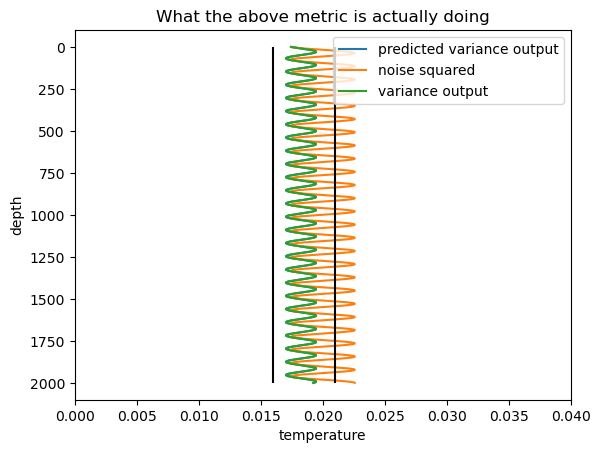

In [59]:
(ds_ensemble.temp_noise**2 + ds_ensemble.temp_noise.mean('profile')**2 - 2*ds_ensemble.temp_noise*ds_ensemble.temp_noise.mean('profile')).mean('profile').plot(y='depth',label='predicted variance output')
plt.plot((ds_ensemble.temp_noise**2).mean('profile'),depth_grid, label='noise squared')
ds_var.plot(y='depth',label='variance output')
plt.gca().invert_yaxis()
plt.xlim(0,0.04)
plt.legend()
plt.vlines([0.016,0.021],2000,0,color='k')
plt.title('What the above metric is actually doing')

This just confirms I know what's being plotted here, where the blue and green profiles are returning the same function. Again, this function isn't exactly the same as the noise added to the profile, but it is only a function of a sin wave (and not the large-scale gradient), which is good.

### Variance using T'(z)

In the first section (without ensemble averaging), the Steinberg methods were applied using the tracer T(z). In the above section, we have defined a new quantity T'(z) = T(z) - T(z)bar. Now try applying the Steinberg methods with T'(z) instead.

In [87]:
temp_anom = ds_ensemble.temperature - ds_ensemble.temperature.mean('profile')
psal_anom = ds_ensemble.salinity - ds_ensemble.salinity.mean('profile')
spic_anom = ds_ensemble.spice - ds_ensemble.spice.mean('profile')

ds_ensemble = ds_ensemble.assign(temp_anom=(['profile','depth'],temp_anom.data))
ds_ensemble = ds_ensemble.assign(psal_anom=(['profile','depth'],psal_anom.data))
ds_ensemble = ds_ensemble.assign(spic_anom=(['profile','depth'],spic_anom.data))
ds_ensemble

<xarray.Dataset>
Dimensions:      (profile: 100, depth: 1000)
Coordinates:
  * profile      (profile) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * depth        (depth) float64 0.0 2.002 4.004 ... 1.996e+03 1.998e+03 2e+03
    MLD          (profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    temperature  (profile, depth) float64 10.19 10.06 9.933 ... 0.1907 0.1949
    salinity     (profile, depth) float64 33.04 33.04 33.05 ... 34.93 34.93
    density      (profile, depth) float64 1.025e+03 1.025e+03 ... 1.037e+03
    spice        (profile, depth) float64 -0.2547 -0.2728 ... -0.1486 -0.1495
    temp_noise   (profile, depth) float64 0.1877 0.1926 0.1963 ... 0.1907 0.1949
    psal_noise   (profile, depth) float64 0.1877 0.1926 0.1963 ... 0.1907 0.1949
    temp_anom    (profile, depth) float64 0.1815 0.1911 0.1996 ... 0.134 0.1371
    psal_anom    (profile, depth) float64 0.02921 0.02876 ... -0.02183 -0.02326
    spic_anom    (profile, depth) float64 0.05319 0.05431 ... -0.007706

In [88]:
ds_anom_EKE = get_EKE(ds_ensemble,lfilter,variable='temp_anom')

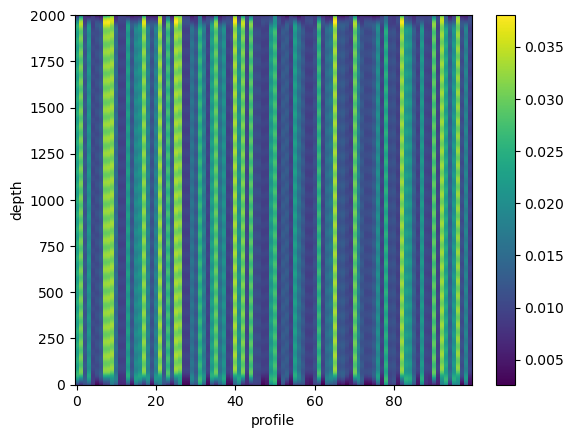

In [89]:
ds_anom_EKE.plot(y='depth')

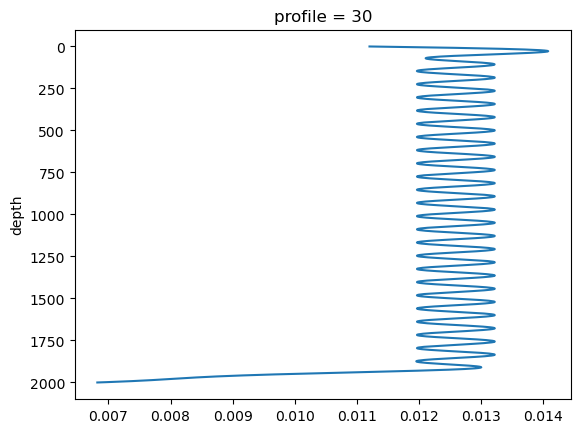

In [94]:
ds_anom_EKE.isel(profile=30).plot(y='depth')
plt.gca().invert_yaxis()